In [1]:
import os
os.chdir("/content/drive/MyDrive/DREAM")
!ls

 Data				       finetune.ipynb	  train.ipynb
'Dream Olfactory Mixtures Plan.gdoc'   preprocess.ipynb   Trials


In [2]:
!pip install torch-geometric

In [3]:
from torch_geometric.data import InMemoryDataset, download_url, Data, Batch

class PairData(Data):
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index_s':
            return self.x_s.size(0)
        if key == 'edge_index_t':
            return self.x_t.size(0)
        return super().__inc__(key, value, *args, **kwargs)

In [4]:
import h5py
import tqdm
import numpy as np
import torch

all_data = []
with h5py.File('Data/train.h5', 'r') as f:
    for label in tqdm.tqdm(f.keys()):
      group = f[label]

      graph_group = group['graph']
      graph_data = {k: torch.tensor(np.array(v)) for k, v in graph_group.items()}
      graph_data = {k: v.float() if not k.startswith("edge_index") else v.long() for k, v in graph_data.items()}
      all_data.append(PairData(**graph_data))

all_data[0]

100%|██████████| 500/500 [00:01<00:00, 411.52it/s]


PairData(y=0.5769230127334595, edge_attr_s=[476, 3], edge_attr_t=[452, 3], edge_index_s=[2, 476], edge_index_t=[2, 452], x_s=[254, 9], x_t=[239, 9])

In [5]:
import sklearn
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(all_data,test_size=150)
len(train), len(test)

(350, 150)

In [6]:
def count_parameters(module):
    return "{:,}".format(sum(p.numel() for p in module.parameters()))

def readout_counts(module):
    results = {"total":count_parameters(module)}
    for n, c in module.named_children():
        results[n] = count_parameters(c)
    return results

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import os

# Shamelessly stolen from (and converted to PytorchGeometric)
# https://lifesci.dgl.ai/_modules/dgllife/model/gnn/mpnn.html
class MPNNGNN(nn.Module):
    """MPNN.

    MPNN is introduced in `Neural Message Passing for Quantum Chemistry
    <https://arxiv.org/abs/1704.01212>`__.

    This class performs message passing in MPNN and returns the updated node representations.

    Parameters
    ----------
    node_in_feats : int
        Size for the input node features.
    node_out_feats : int
        Size for the output node representations.
    edge_in_feats : int
        Size for the input edge features.
    edge_hidden_feats : int
        Size for the hidden edge representations.
    num_step_message_passing : int
        Number of message passing steps.
    """
    def __init__(self, node_in_feats, edge_in_feats, node_out_feats,
                 edge_hidden_feats, num_step_message_passing, dropout):
        super(MPNNGNN, self).__init__()

        # This should be changed to node wise dropout. But maybe not?
        # See https://arxiv.org/pdf/1411.4280
        self.project_node_feats = nn.Sequential(
            nn.Linear(node_in_feats, node_out_feats),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.num_step_message_passing = num_step_message_passing
        edge_network = nn.Sequential(
            nn.Linear(edge_in_feats, edge_hidden_feats),
            nn.ReLU(), # Could add dropout after this.
            nn.Linear(edge_hidden_feats, node_out_feats * node_out_feats),
            nn.Dropout(dropout) # This one is after the largest by far.
        )

        self.gnn_layer = tg.nn.conv.NNConv(
            in_channels=node_out_feats,
            out_channels=node_out_feats,
            nn=edge_network,
            aggr='sum' # If this doesn't work, try `aggregator_type='sum'`

        )

        # If we add a second layer, we could add dropout.
        self.gru = nn.GRU(node_out_feats, node_out_feats,bidirectional=False)
        self.final_dropout = nn.Dropout(dropout)


    def forward(self, graph):
        """Performs message passing and updates node representations.

        Parameters
        ----------
        g : DGLGraph
            DGLGraph for a batch of graphs.
        node_feats : float32 tensor of shape (V, node_in_feats)
            Input node features. V for the number of nodes in the batch of graphs.
        edge_feats : float32 tensor of shape (E, edge_in_feats)
            Input edge features. E for the number of edges in the batch of graphs.

        Returns
        -------
        node_feats : float32 tensor of shape (V, node_out_feats)
            Output node representations.
        """
        node_feats = graph.x
        edge_feats = graph.edge_attr
        node_feats = self.project_node_feats(node_feats) # (V, node_out_feats)
        hidden_feats = node_feats.unsqueeze(0)           # (1, V, node_out_feats)

        for _ in range(self.num_step_message_passing):
            node_feats = F.relu(self.gnn_layer(node_feats, graph.edge_index, edge_feats))
            node_feats, hidden_feats = self.gru(node_feats.unsqueeze(0), hidden_feats)
            node_feats = self.final_dropout(node_feats.squeeze(0))

        return node_feats

# My sense is that we should have multiple convolutions
# Earlier convolutions have more message passing steps (equivalent to kernel size)
# but smaller node/hidden feature sizes (equivalent to channels).
# AlexNet pools between some of the convolutions.
# I'm unsure what would be the equivalent. How would we merge nodes?
# Also, we could maybe augment the graphs with edges (decrease or increase over time)
class Encoder(torch.nn.Module):
    def __init__(self,node_out_feats,edge_hidden_feats,num_step_message_passing, num_sabs, heads, dropout):
        super(Encoder, self).__init__()
        self.conv = MPNNGNN(node_in_feats=9,edge_in_feats=3,node_out_feats=node_out_feats,edge_hidden_feats=edge_hidden_feats,num_step_message_passing=num_step_message_passing,dropout=dropout)
        # https://github.com/davidbuterez/multi-fidelity-gnns-for-drug-discovery-and-quantum-mechanics/blob/3f39d12b66447f62960bf9e4b45070b266328555/schnet_multiple_fidelities/schnet_high_fidelity.py#L159
        # self.readout = tg.nn.aggr.set_transformer.SetTransformerAggregation(node_out_feats,heads=8,num_encoder_blocks=2,num_decoder_blocks=2,dropout=dropout)
        self.readout = tg.nn.aggr.set_transformer.SetTransformerAggregation(node_out_feats,heads=heads,num_encoder_blocks=num_sabs,num_decoder_blocks=num_sabs,dropout=dropout)

    # Cannot get gradient checkpointing to work b/c the SetTransformerAggregation
    # computes dropout internally and doesn't allow checkpointing.
    # We can't combine checkpointing and gradient checkpointing without causing issues.
    # So we could commit to no dropout.
    def forward(self,graph):
        x = self.conv(graph)
        if "batch" in graph:
            return self.readout(x,graph.batch)
        return self.readout(x)

    def count_parameters(self):
        return {"total":count_parameters(self), "conv":count_parameters(self.conv), "readout":count_parameters(self.readout)}


In [8]:
class CrossEncoder(torch.nn.Module):
    def __init__(self,encoder, cosine_similarity):
        super(CrossEncoder, self).__init__()
        self.encoder = encoder
        self.cosine_similarity = cosine_similarity
        if not self.cosine_similarity:
          self.readout = torch.nn.Linear(self.encoder.readout.channels*2,1)


    def _make_batches(self,pair_graph):
      graph1 = Batch(
          x=pair_graph.x_s,
          edge_index=pair_graph.edge_index_s,
          edge_attr=pair_graph.edge_attr_s,
          batch=pair_graph.x_s_batch,
          ptr=pair_graph.x_s_ptr
      )

      graph2 = Batch(
          x=pair_graph.x_t,
          edge_index=pair_graph.edge_index_t,
          edge_attr=pair_graph.edge_attr_t,
          batch=pair_graph.x_t_batch,
          ptr=pair_graph.x_t_ptr
      )
      return graph1, graph2

    def _make_data(self,pair_graph):
      graph1 = Data(
          x=pair_graph.x_s,
          edge_index=pair_graph.edge_index_s,
          edge_attr=pair_graph.edge_attr_s,
      )

      graph2 = Data(
          x=pair_graph.x_t,
          edge_index=pair_graph.edge_index_t,
          edge_attr=pair_graph.edge_attr_t,
      )
      return graph1, graph2

    def forward(self,pair_graph):
      if isinstance(pair_graph,Batch):
        graph1, graph2 = self._make_batches(pair_graph)
      else:
        graph1, graph2 = self._make_data(pair_graph)

      embed1 = self.encoder(graph1)
      embed2 = self.encoder(graph2)

      if self.cosine_similarity:
        return torch.nn.functional.cosine_similarity(embed1,embed2)

      return torch.nn.functional.sigmoid(self.readout(torch.cat([embed1,embed2],dim=-1))).squeeze(dim=-1)


In [9]:
from torch_geometric.loader import DataLoader

def make_model(model_path,cosine_similarity):
  config = torch.load(os.path.join(model_path,"config.pt"))
  encoder = Encoder(**config)
  encoder.load_state_dict(torch.load(os.path.join(model_path,"model.pt")))
  return CrossEncoder(encoder,cosine_similarity=True)

bsz = 64
train_loader = DataLoader(train, batch_size=bsz, follow_batch=['x_s', 'x_t'], drop_last=True, shuffle=True)
test_loader = DataLoader(test, batch_size=bsz, follow_batch=['x_s', 'x_t'], drop_last=True, shuffle=True)

model = make_model("Trials/4f5a92/step2271",True)
model.cuda()

optimizer = torch.optim.Adam(model.parameters(),lr=1e-5,betas=(0.9, 0.98),weight_decay=.01)
scaler = torch.cuda.amp.GradScaler()

def calc_loss(batch):
  batch.cuda()
  pred = model(batch)
  # Leadboard is using RMSE
  return torch.nn.functional.mse_loss(pred,batch.y)

def calc_test_rmse():
  tls = []
  with torch.no_grad():
    for tbatch in test_loader:
      with torch.cuda.amp.autocast():
        tls.append(calc_loss(tbatch).cpu().detach().numpy())
  return np.sqrt(np.mean(tls))

train_losses = []
test_losses = []

epochs = 20
for epoch in tqdm.tqdm(range(epochs)):
  btls = []
  for batch in train_loader:
    with torch.cuda.amp.autocast():
      loss = calc_loss(batch)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    optimizer.zero_grad()
    btls.append(loss.cpu().detach())
    batch.cpu()

  tl = calc_test_rmse()
  test_losses.append(tl)
  train_losses.append(np.sqrt(np.mean(btls)))
  print(f"\nTrain = {train_losses[-1]:.3f}. Test = {test_losses[-1]:.3f}")

  5%|▌         | 1/20 [00:04<01:16,  4.01s/it]


Train = 0.275. Test = 0.295


 10%|█         | 2/20 [00:07<01:01,  3.41s/it]


Train = 0.264. Test = 0.276


 15%|█▌        | 3/20 [00:10<00:54,  3.23s/it]


Train = 0.251. Test = 0.272


 20%|██        | 4/20 [00:13<00:50,  3.14s/it]


Train = 0.234. Test = 0.246


 25%|██▌       | 5/20 [00:16<00:46,  3.09s/it]


Train = 0.220. Test = 0.239


 30%|███       | 6/20 [00:18<00:42,  3.04s/it]


Train = 0.214. Test = 0.214


 35%|███▌      | 7/20 [00:21<00:39,  3.03s/it]


Train = 0.209. Test = 0.219


 40%|████      | 8/20 [00:25<00:36,  3.03s/it]


Train = 0.199. Test = 0.219


 45%|████▌     | 9/20 [00:27<00:33,  3.02s/it]


Train = 0.199. Test = 0.210


 50%|█████     | 10/20 [00:31<00:30,  3.01s/it]


Train = 0.196. Test = 0.210


 55%|█████▌    | 11/20 [00:34<00:27,  3.04s/it]


Train = 0.187. Test = 0.201


 60%|██████    | 12/20 [00:37<00:24,  3.04s/it]


Train = 0.182. Test = 0.220


 65%|██████▌   | 13/20 [00:40<00:21,  3.04s/it]


Train = 0.200. Test = 0.217


 70%|███████   | 14/20 [00:43<00:18,  3.03s/it]


Train = 0.193. Test = 0.212


 75%|███████▌  | 15/20 [00:46<00:15,  3.02s/it]


Train = 0.182. Test = 0.193


 80%|████████  | 16/20 [00:49<00:12,  3.00s/it]


Train = 0.182. Test = 0.201


 85%|████████▌ | 17/20 [00:52<00:08,  2.99s/it]


Train = 0.180. Test = 0.200


 90%|█████████ | 18/20 [00:55<00:05,  2.99s/it]


Train = 0.187. Test = 0.199


 95%|█████████▌| 19/20 [00:58<00:02,  2.98s/it]


Train = 0.183. Test = 0.197


100%|██████████| 20/20 [01:01<00:00,  3.05s/it]


Train = 0.186. Test = 0.208


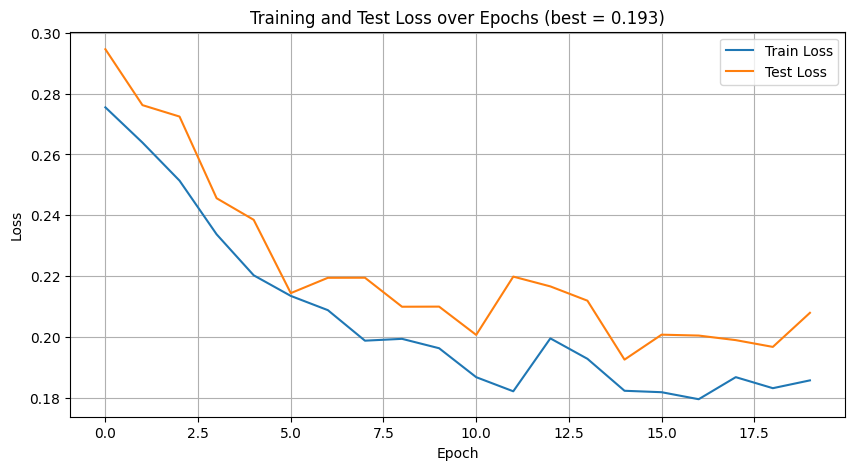

In [10]:
import matplotlib.pyplot as plt

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training and Test Loss over Epochs (best = {min(test_losses):.3f})')
# plt.ylim((0,max(train_losses+test_losses)))
plt.legend()
plt.grid(True)
plt.show()